## ThinkDSP

This notebook contains code examples from Chapter 11: Modulation and sampling

Copyright 2015 Allen Downey

Special thanks to my colleague Siddhartan Govindasamy; the sequence of topics in this notebook is based on material he developed for Signals and Systems at Olin College, which he and Oscar Mur-Miranda and I co-taught in Spring 2015.

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Convolution with impulses

To demonstrate the effect of convolution with impulses, I'll load a short beep sound.

In [3]:
if not os.path.exists('253887__themusicalnomad__positive-beeps.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/253887__themusicalnomad__positive-beeps.wav

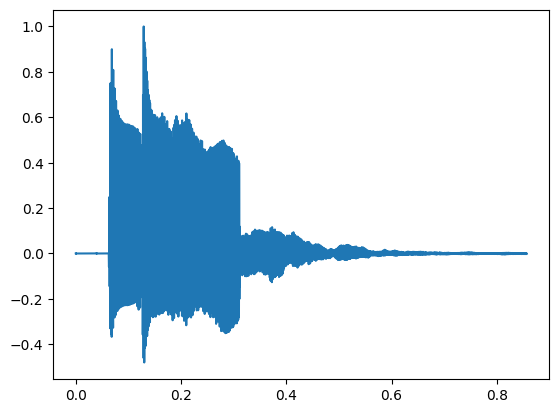

In [4]:
from thinkdsp import read_wave

wave = read_wave('253887__themusicalnomad__positive-beeps.wav')
wave.normalize()
wave.plot()

Here's what it sounds like.

In [5]:
wave.make_audio()

And here's a sequence of 4 impulses with diminishing amplitudes:

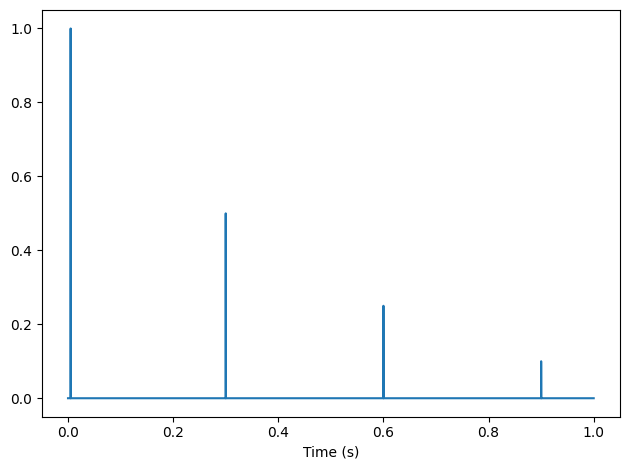

In [6]:
from thinkdsp import Impulses

imp_sig = Impulses([0.005, 0.3, 0.6, 0.9], amps=[1, 0.5, 0.25, 0.1])
impulses = imp_sig.make_wave(start=0, duration=1.0, framerate=wave.framerate)
impulses.plot()
decorate(xlabel='Time (s)')

If we convolve the wave with the impulses, we get 4 shifted, scaled copies of the original sound.

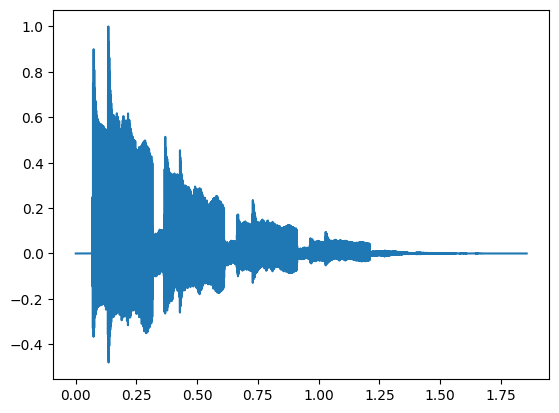

In [7]:
convolved = wave.convolve(impulses)
convolved.plot()

And here's what it sounds like.

In [8]:
convolved.make_audio()

## Amplitude modulation (AM)

The previous example gives some insight into how AM works.

First I'll load a recording that sounds like AM radio.

In [9]:
if not os.path.exists('105977__wcfl10__favorite-station.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/105977__wcfl10__favorite-station.wav

In [10]:
wave = read_wave('105977__wcfl10__favorite-station.wav')
wave.unbias()
wave.normalize()
wave.make_audio()

Here's what the spectrum looks like:

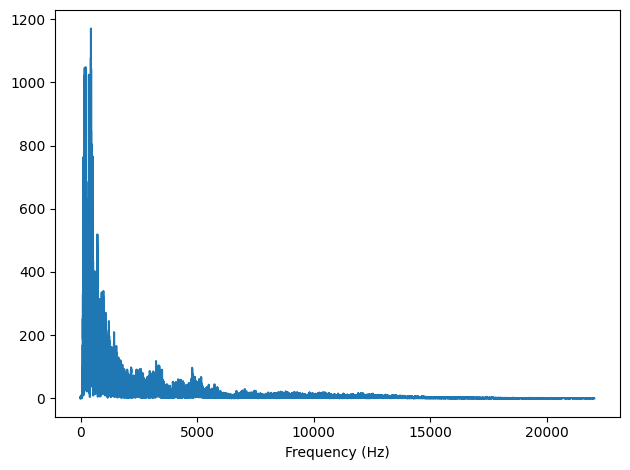

In [11]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

For the following examples, it will be more useful to look at the full spectrum, which includes the negative frequencies.  Since we are starting with a real signal, the spectrum is always symmetric.

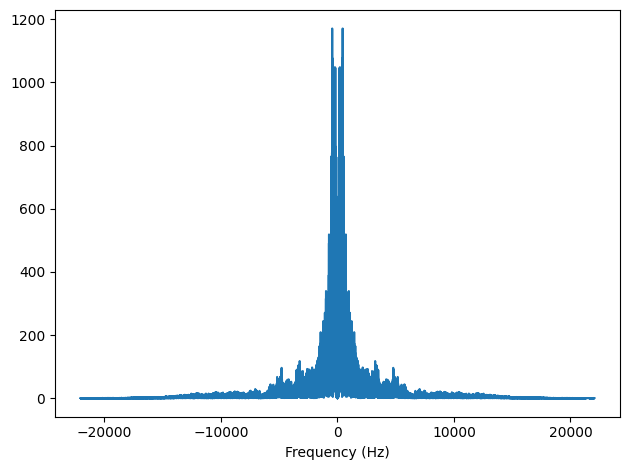

In [12]:
spectrum = wave.make_spectrum(full=True)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Amplitude modulation works my multiplying the input signal by a "carrier wave", which is a cosine, 10 kHz in this example.

In [13]:
from thinkdsp import CosSignal

carrier_sig = CosSignal(freq=10000)
carrier_wave = carrier_sig.make_wave(duration=wave.duration, framerate=wave.framerate)

The `*` operator performs elementwise multiplication.

In [14]:
modulated = wave * carrier_wave

The result sounds pretty horrible.

In [ ]:
modulated.make_audio() # Ну его и не надо в таком виде слушать, разве нет

Why?  Because multiplication in the time domain corresponds to convolution in the frequency domain.  The DFT of the carrier wave is two impulses; convolution with those impulses makes shifted, scaled copies of the spectrum.

Specifically, AM modulation has the effect of splitting the spectrum in two halves and shifting the frequencies by 10 kHz (notice that the amplitudes are half what they were in the previous plot).

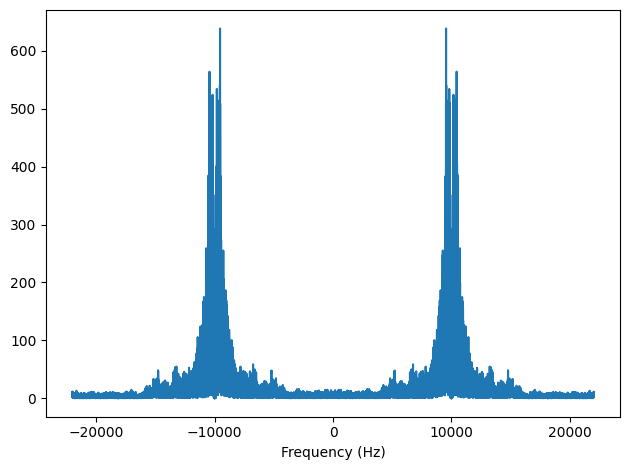

In [16]:
modulated.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

To recover the signal, we modulate it again.

In [17]:
demodulated = modulated * carrier_wave

Each half of the spectrum gets split and shifted again.  Two of the quarters get shifted to 0 and added up.  The other two are at $\pm$20Khz

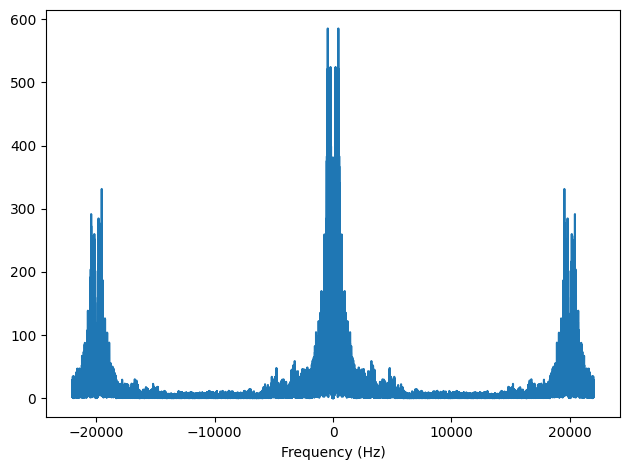

In [18]:
demodulated_spectrum = demodulated.make_spectrum(full=True)
demodulated_spectrum.plot()
decorate(xlabel='Frequency (Hz)')

If you listen to it now, it sounds pretty good.  You probably can't hear the extra components at high frequencies.

In [19]:
demodulated.make_audio()

If we compare the input and output signals, they are pretty close.

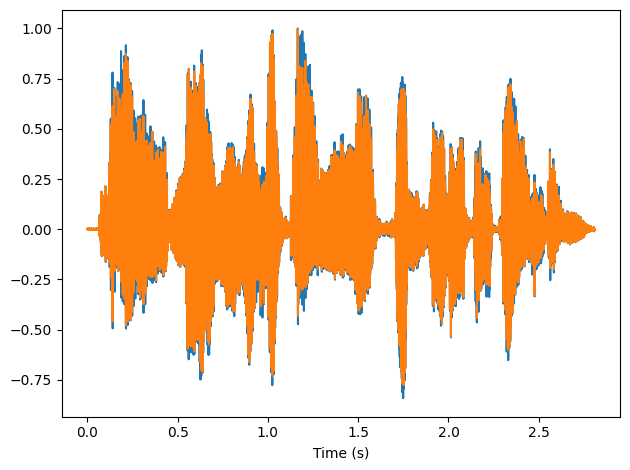

In [20]:
wave.plot()
demodulated.plot()
decorate(xlabel='Time (s)')

If the high frequency components bother you, you can clobber them by applying a low pass filter.  In this example, I use a "brick wall" filter that cuts off sharply at 10 kHz.  In real applications, we would use a more gentle filter.

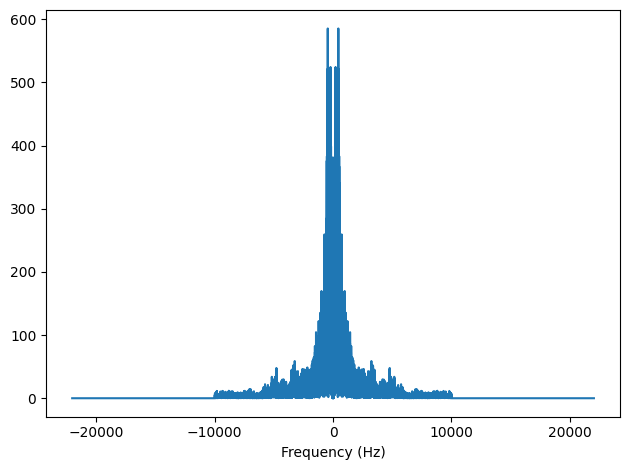

In [21]:
demodulated_spectrum.low_pass(10000)
demodulated_spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Here's what it sounds like after filtering.

In [ ]:
filtered = demodulated_spectrum.make_wave()
filtered.make_audio() # Вот так то лучше

To understand how AM works, let's see what's going on in the frequency domain.

When we multiply two signals in the time domain, that corresponds to convolution in the frequency domain.  The carrier wave is a cosine at 10 kHz, so its spectrum is two impulses, at $\pm$ 10 kHz

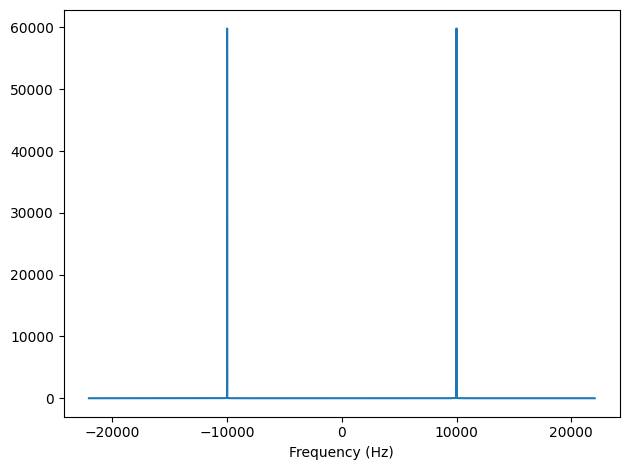

In [23]:
carrier_spectrum = carrier_wave.make_spectrum(full=True)
carrier_spectrum.plot()
decorate(xlabel='Frequency (Hz)')

As we saw in the beep example, convolution with impulses makes shifted, scaled copies.

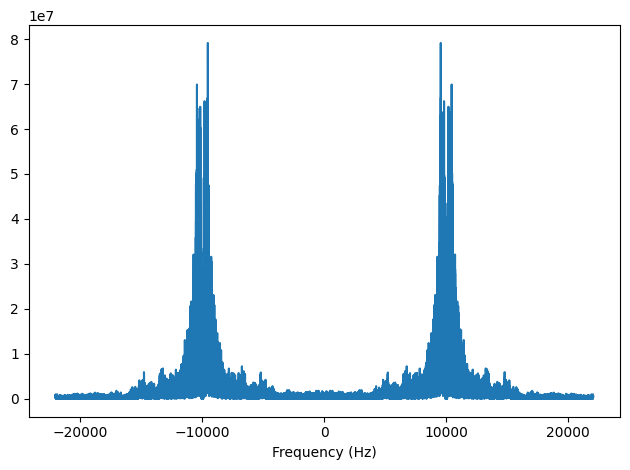

In [24]:
convolved = spectrum.convolve(carrier_spectrum)
convolved.plot()
decorate(xlabel='Frequency (Hz)')

After one convolution, we have two peaks.  After two convolutions, we have four.

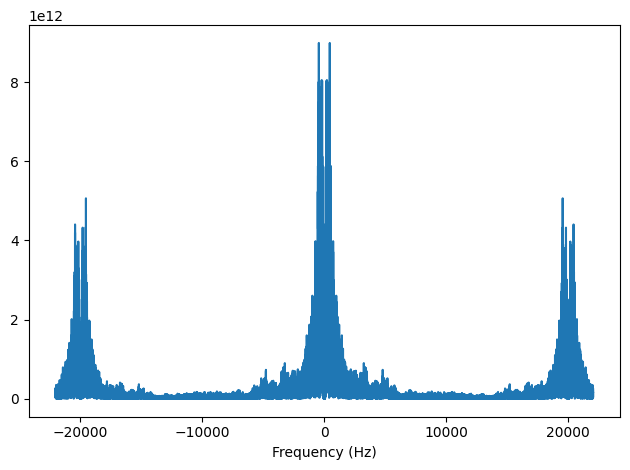

In [25]:
reconvolved = convolved.convolve(carrier_spectrum)
reconvolved.plot()
decorate(xlabel='Frequency (Hz)')

And that's how AM works.  Now let's talk about sampling.

## Sampling

I'll start with a recording of a drum break.  If you don't know about the Amen break, you might want to read this: https://en.wikipedia.org/wiki/Amen_break

In [101]:
if not os.path.exists('263868__kevcio__amen-break-a-160-bpm.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/263868__kevcio__amen-break-a-160-bpm.wav

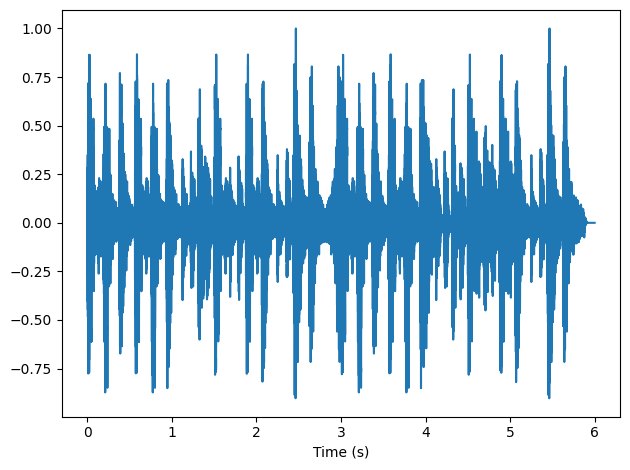

In [102]:
wave = read_wave('263868__kevcio__amen-break-a-160-bpm.wav')
wave.normalize()
wave.plot()
decorate(xlabel='Time (s)')

This signal is sampled at 44100 Hz.  Here's what it sounds like.

In [103]:
wave.make_audio() # Легендарный семпл

And here's the spectrum:

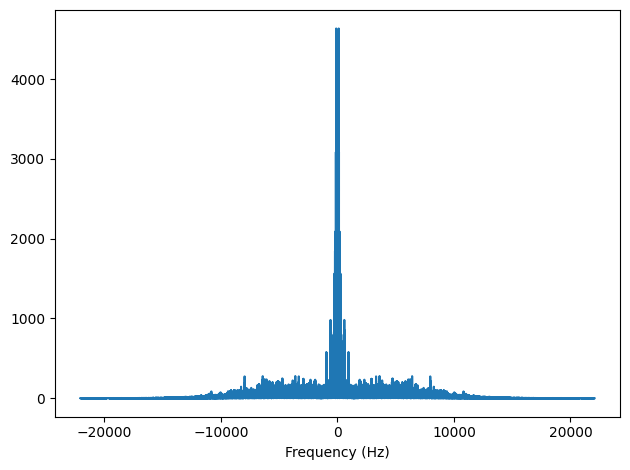

In [104]:
wave.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

In [ ]:
factor = 4
framerate = wave.framerate / factor
cutoff = framerate / 2 - 1


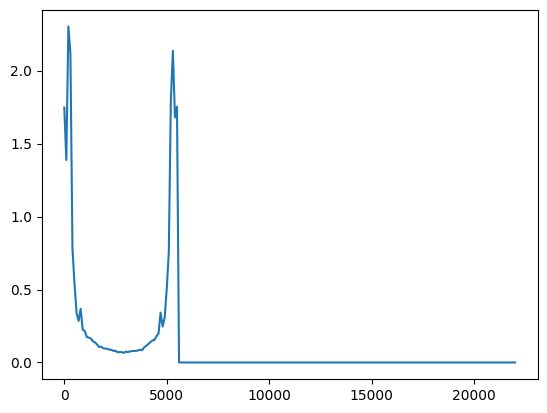

In [107]:
spectrum.low_pass(cutoff) # Применяем фильтр НЧ до выборки
spectrum.plot()

Even though this signal has already been sampled, let's pretend it hasn't.  So we'll treat the original wave as if it were a continuous analog signal.

Now I'm going to sample it at 1/4 of the framerate (11025 Hz) by keeping every 4th sample and setting the rest to zero.

In [65]:
from thinkdsp import Wave

def sample(wave, factor):
    """Simulates sampling of a wave.
    
    wave: Wave object
    factor: ratio of the new framerate to the original
    """
    ys = np.zeros(len(wave))
    ys[::factor] = wave.ys[::factor]
    return Wave(ys, framerate=wave.framerate) 

The result doesn't sound very good.  It has a bunch of extra high frequency components.

In [66]:
sampled = sample(wave, 4)
sampled.make_audio()

If we look at the spectrum, we can see the extra components.

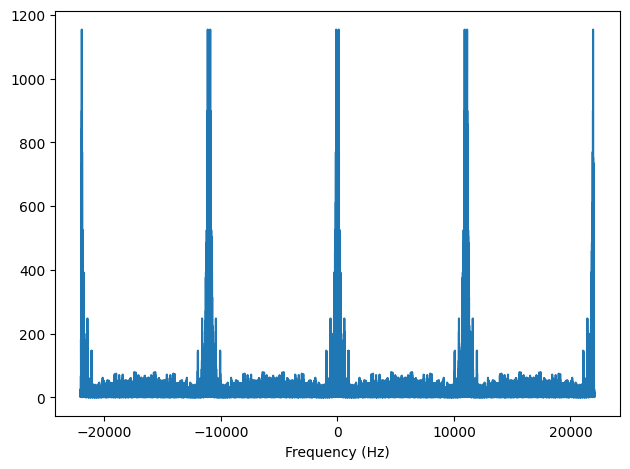

In [67]:
sampled.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

To understand where those came from, it helps to think of sampling as multiplication with an "impulse train".  The following function is similar to `sample`, but it makes the impulse train explicit.

In [33]:
def make_impulses(wave, factor):
    ys = np.zeros(len(wave))
    ys[::factor] = 1
    ts = np.arange(len(wave)) / wave.framerate
    return Wave(ys, ts, wave.framerate)

impulses = make_impulses(wave, 4)

Multiplying by `impulses` has the same effect as `sample`.

In [34]:
sampled = wave * impulses
sampled.make_audio()

Now if we look at the spectrum of `impulses`, we can see what's going on in the frequency domain.

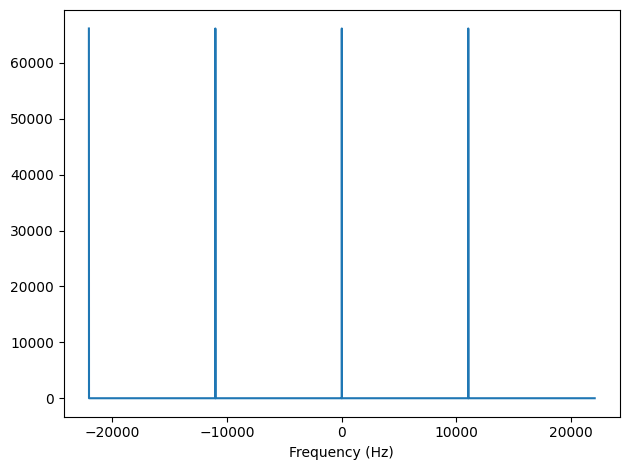

In [68]:
impulses.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

Multiplying by `impulses` makes 4 shifted copies of the original spectrum.  One of them wraps around from the negative end of the spectrum to the positive, which is why there are 5 peaks in the spectrum off the sampled wave.

In [69]:
def show_impulses(wave, factor):
    impulses = make_impulses(wave, factor)
    plt.subplot(1, 2, 1)
    impulses.segment(0, 0.001).plot_vlines(linewidth=2)
    decorate(xlabel='Time (s)')
    
    plt.subplot(1, 2, 2)
    impulses.make_spectrum(full=True).plot()
    decorate(xlabel='Frequency (Hz)', xlim=[-22400, 22400])

As we take fewer samples, they get farther apart in the time domain and the copies of the spectrum get closer together in the frequency domain.

As you vary the sampling factor, below, you can see the effect.

In [70]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=32, value=4)
interact(show_impulses, wave=fixed(wave), factor=slider);

interactive(children=(IntSlider(value=4, description='factor', max=32, min=2), Output()), _dom_classes=('widge…

To recover the original wave, we can apply a low pass filter to clobber the unwanted copies.  The wave was sampled at 11025 Hz, so we'll cut it off at the Nyquist frequency, 5512.5.

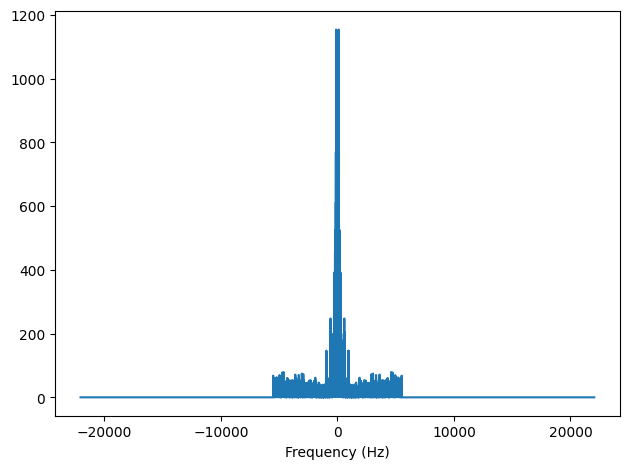

In [71]:
spectrum = sampled.make_spectrum(full=True)
spectrum.low_pass(5512.5)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

The result sounds quite different from the original, for two reasons:

1. Because we had to cut off frequencies about 5512.5 Hz, we lost some of the high frequency components of the original signal.
2. Even for the frequencies below 5512.5 Hz, the spectrum is not quite right, because it includes contributions leftover from the extra copies.

In [72]:
filtered = spectrum.make_wave()
filtered.make_audio()

We can see that the original and the sampled/filtered signal are not the same:

In [73]:
def plot_segments(original, filtered):
    start = 1
    duration = 0.01
    original.segment(start=start, duration=duration).plot(color='gray')
    filtered.segment(start=start, duration=duration).plot()

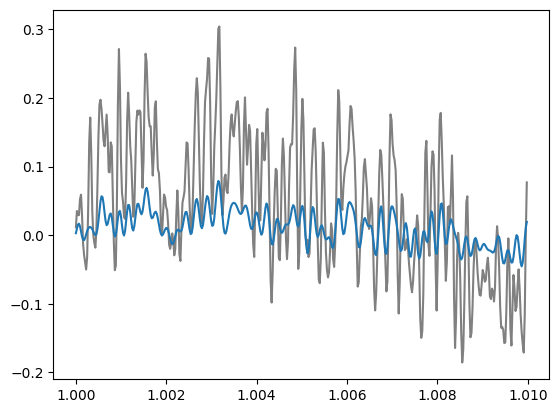

In [74]:
plot_segments(wave, filtered)

Sampling didn't work very well with this signal because it contains a lot of components above the Nyquist frequency.

## Sampling, take two

Let's try again with a bass guitar intro (can you name that tune?).


In [75]:
if not os.path.exists('328878__tzurkan__guitar-phrase-tzu.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/328878__tzurkan__guitar-phrase-tzu.wav

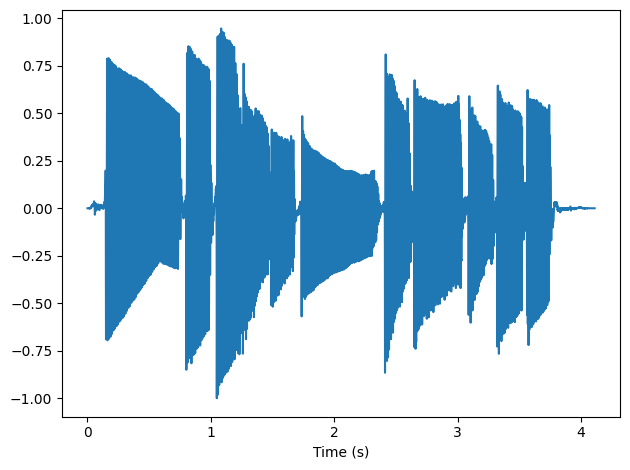

In [76]:
wave = read_wave('328878__tzurkan__guitar-phrase-tzu.wav')
wave.normalize()
wave.plot()
decorate(xlabel='Time (s)')

Unless you have good speakers, it might not sound very good.

In [77]:
wave.make_audio()

Here's the spectrum.  Not a lot of high frequency components!

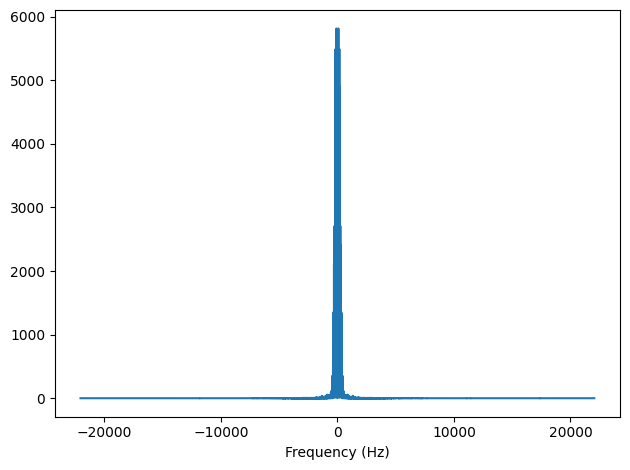

In [78]:
wave.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

Here's the spectrum after sampling:

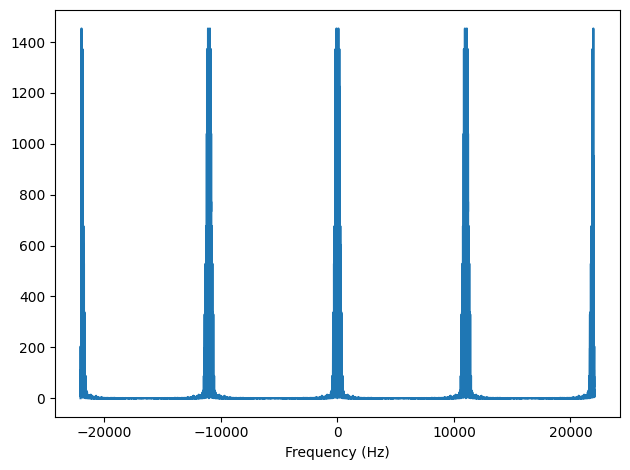

In [79]:
sampled = sample(wave, 4)
sampled.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

And here's what it sounds like:

In [80]:
sampled.make_audio()

Now, instead of using `Spectrum.low_pass`, I'm going to make the low pass filter explicitly.  I'm calling it `boxcar` because it looks like the boxcar smoothing window from Chapter 8.

In [81]:
from thinkdsp import Spectrum

def make_boxcar(spectrum, factor):
    """Makes a boxcar filter for the given spectrum.
    
    spectrum: Spectrum to be filtered
    factor: sampling factor
    """
    fs = np.copy(spectrum.fs)
    hs = np.zeros_like(spectrum.hs)
    
    cutoff = spectrum.framerate / 2 / factor
    for i, f in enumerate(fs):
        if abs(f) <= cutoff:
            hs[i] = 1
    return Spectrum(hs, fs, spectrum.framerate, full=spectrum.full)

Here's what it looks like:

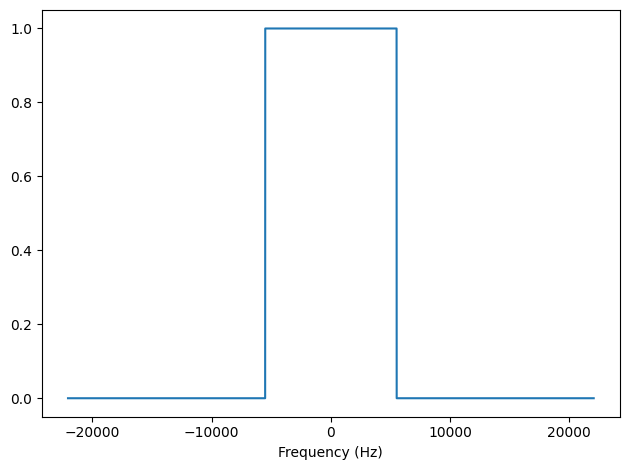

In [82]:
spectrum = sampled.make_spectrum(full=True)
boxcar = make_boxcar(spectrum, 4)
boxcar.plot()
decorate(xlabel='Frequency (Hz)')

Now we can apply the filter by multiplying in the frequency domain.

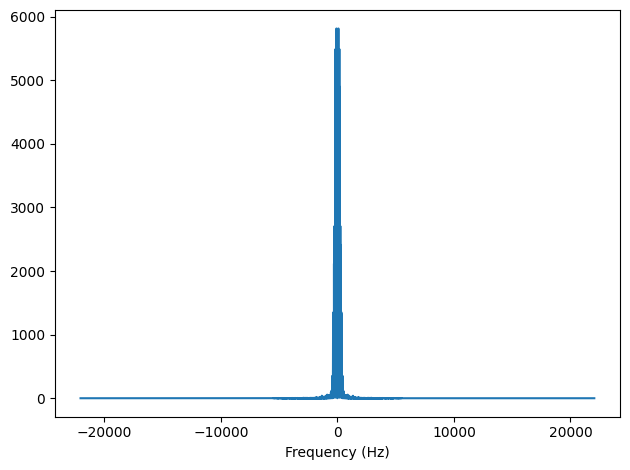

In [83]:
filtered = (spectrum * boxcar).make_wave()
filtered.scale(4)
filtered.make_spectrum(full=True).plot()
decorate(xlabel='Frequency (Hz)')

Now if we listen to the sampled/filtered wave, it sounds pretty good.

In [84]:
filtered.make_audio()

And if we compare it to the original, it is almost identical.

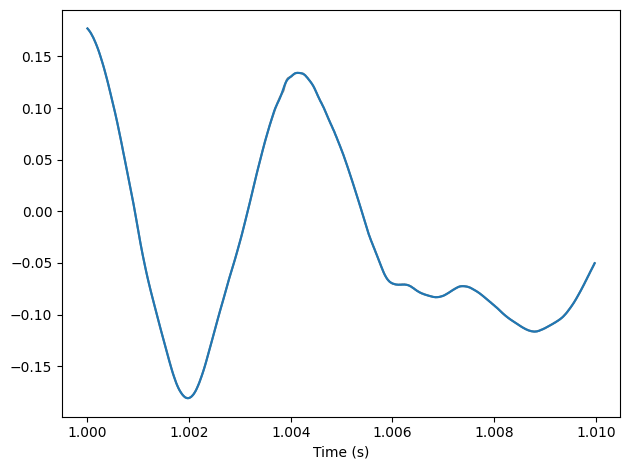

In [85]:
plot_segments(wave, filtered)
decorate(xlabel='Time (s)')

It's not completely identical because the original signal had some tiny components above the Nyquist frequency.  But the differences are small.

np.float64(0.00010351541888097281)

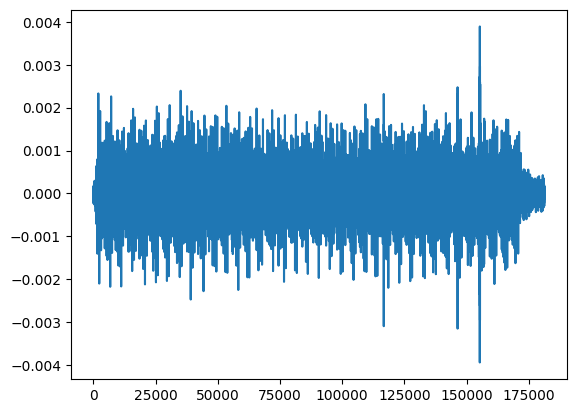

In [86]:
diff = wave.ys - filtered.ys
plt.plot(diff.real)
np.mean(abs(diff))

Multiplying the spectrum of the sampled signal and the boxcar filter, in the frequency domain, corresponds to convolution in the time domain.  And you might wonder what the convolution window looks like.  We can find out by computing the wave that corresponds to the boxcar filter.

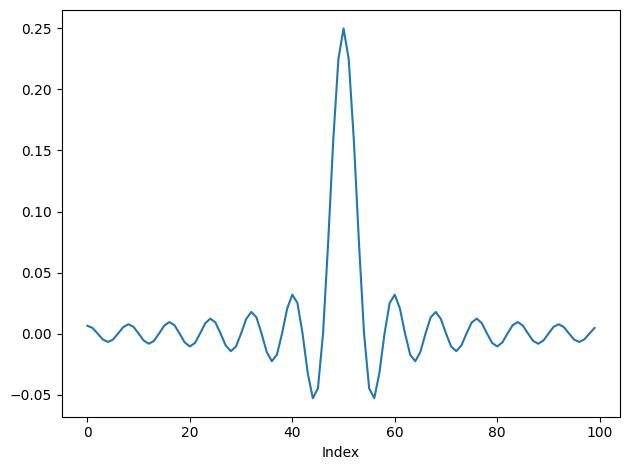

In [87]:
sinc = boxcar.make_wave()
ys = np.roll(sinc.ys, 50)
plt.plot(ys[:100].real)
decorate(xlabel='Index')

It's the sinc function, which you can read about at https://en.wikipedia.org/wiki/Sinc_function

## Sinc interpolation

Multiplying by a boxcar filter corresponds to convolution with a sinc function, which has the effect of interpolating between the samples.  To see how that works, let's zoom in on a short segment of the signal:

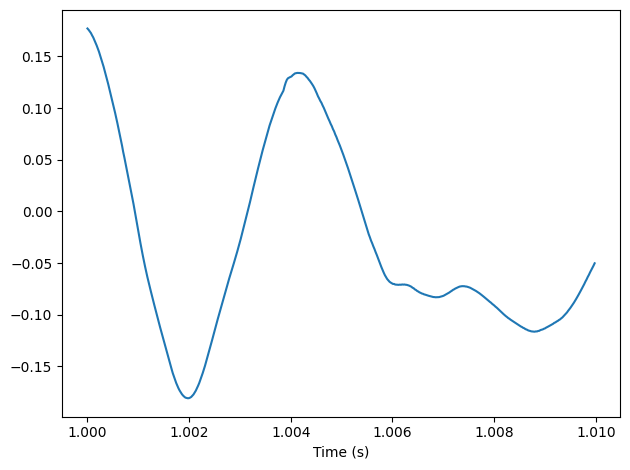

In [88]:
start = 1.0
duration = 0.01
factor = 8

short = wave.segment(start=start, duration=duration)
short.plot()
decorate(xlabel='Time (s)')

Now I'll sample the signal and show the samples using vertical lines:

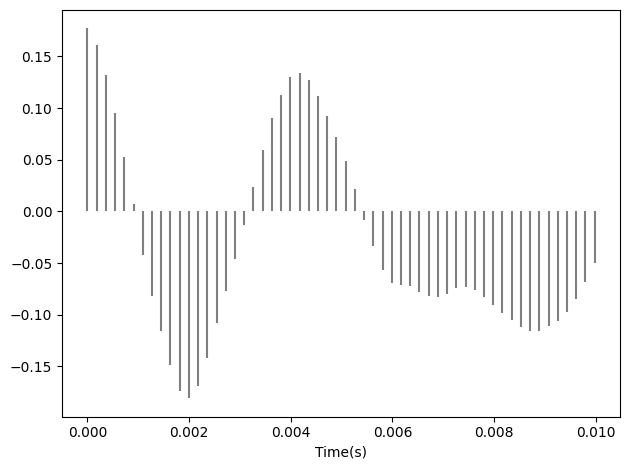

In [89]:
sampled = sample(short, factor)
sampled.plot_vlines(color='gray')
decorate(xlabel='Time(s)')

We can use the sampled spectrum to construct the sinc function.  In this example I

1. Shift the sinc function in time so it lines up with the sampled segment (both start at 1.0 seconds).

2. Roll the sinc function so the peak is in the middle, just because it looks better that way.

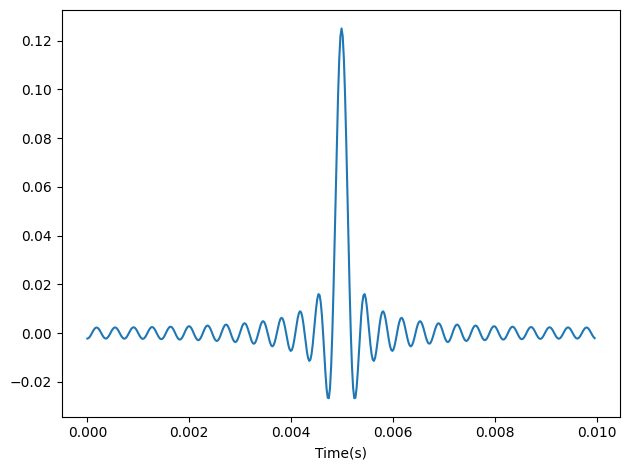

In [90]:
spectrum = sampled.make_spectrum()
boxcar = make_boxcar(spectrum, factor)
sinc = boxcar.make_wave()
sinc.shift(sampled.ts[0])
sinc.roll(len(sinc)//2)

sinc.plot()
decorate(xlabel='Time(s)')

The following figure shows how convolution makes lots of shifted, scaled copies of the sinc function and adds them up. 

In [91]:
def plot_sinc_demo(wave, factor, start=None, duration=None):

    def make_sinc(t, i, y):
        """Makes a shifted, scaled copy of the sinc function."""
        sinc = boxcar.make_wave()
        sinc.shift(t)
        sinc.roll(i)
        sinc.scale(y * factor)
        return sinc
 
    def plot_sincs(wave):
        """Plots sinc functions for each sample in wave."""
        t0 = wave.ts[0]
        for i in range(0, len(wave), factor):
            sinc = make_sinc(t0, i, wave.ys[i])
            seg = sinc.segment(start, duration)
            seg.plot(color='green', linewidth=0.5, alpha=0.3)
            if i == 0:
                total = sinc
            else:
                total += sinc
            
        seg = total.segment(start, duration)        
        seg.plot(color='blue', alpha=0.5)

    sampled = sample(wave, factor)
    spectrum = sampled.make_spectrum()
    boxcar = make_boxcar(spectrum, factor)

    start = wave.start if start is None else start
    duration = wave.duration if duration is None else duration
        
    sampled.segment(start, duration).plot_vlines(color='gray')
    wave.segment(start, duration).plot(color='gray')
    plot_sincs(wave)

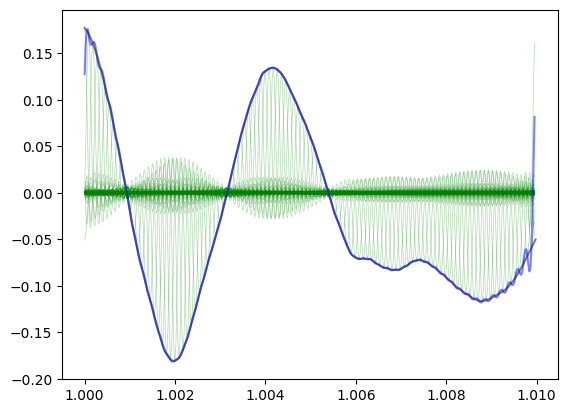

In [92]:
# CAUTION: don't call plot_sinc_demo with a large wave or it will
# fill memory and crash
plot_sinc_demo(short, 4)

In this figure:

1. The thin green lines are the shifted, scaled copies of the sinc function.
2. The blue line is the sum of the sinc functions.
3. The gray line (which you mostly can't see) is the original function.

The sum of the sinc functions interpolates between the samples and recovers the original wave.  At the beginning and end, where the interpolation deviates from the original; the problem is that the original is not periodic, so the sinc interpolation breaks at the boundaries.

If we zoom in on a short segment, we can see how it works more clearly.

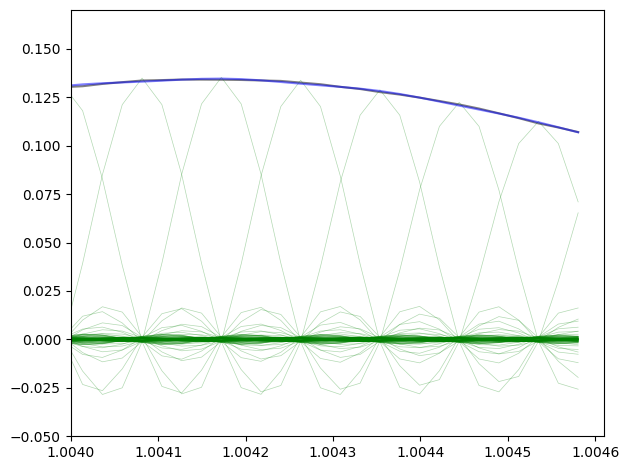

In [93]:
start = short.start + 0.004
duration = 0.00061
plot_sinc_demo(short, 4, start, duration)
decorate(xlim=[start, start+duration],
         ylim=[-0.05, 0.17])

The vertical gray lines are the samples.

Again, the thin green lines are the shifted, scaled copies of the sinc function.

In this segment, the interpolation matches the original wave very well.

Notice that each sinc function has a peak at the location of one sample and the value 0 at every other sample location.  That way, when we add them up, the sum passes through each of the samples.

# ВЫПОЛНЕНИЕ ЗАДАНИЙ

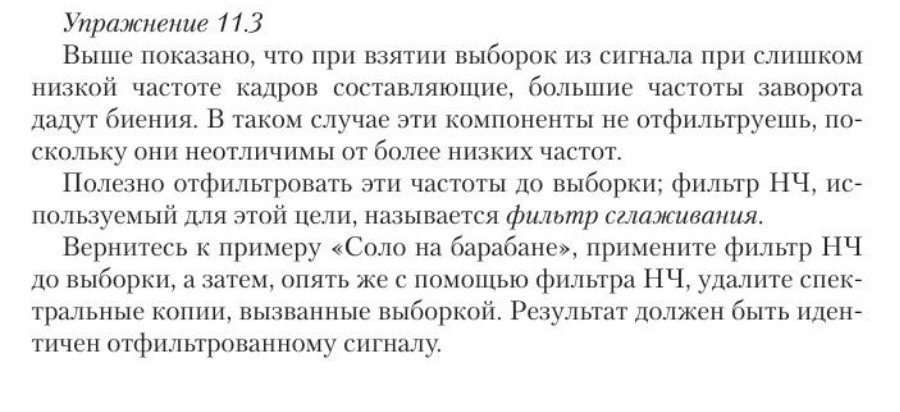